# Get the MF as the average of different simulations 

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import lenscarf
# import matplotlib as mpl

import pylab as pl

import numpy as np
from lenscarf.utils import cli
from lenscarf import utils
from lenscarf import utils_hp as uhp
from lenscarf.iterators import statics
from plancklens.sims import maps, phas, planck2018_sims
from lenscarf.cpp_sims import cpp_sims_lib
from lenscarf import rdn0_cs
from plancklens.utils import stats, enumerate_progress
import plancklens.utils as ut
import healpy as hp
from os.path import join as opj
import os

import importlib

from lenscarf.utils_plot import set_mpl, pp2kk, plot_bnd, bnd
from scipy.interpolate import UnivariateSpline as spline

# set_mpl()

In [5]:
import matplotlib.cm as cm

In [6]:
set_mpl(usetex=False)

In [7]:
def w(ell):
    return pp2kk(ell) * 1e7 * 2/np.pi


def get_cl(cppsim, alm, blm=None):
    if blm is None: blm = alm 
    return uhp.alm2cl(alm, blm, cppsim.param.lmax_qlm, cppsim.param.mmax_qlm, None)

def almxfl(cppsim, alm, cl):
    return uhp.almxfl(alm, cl, mmax = cppsim.param.mmax_qlm, inplace=False)

In [8]:
# idealpp = cpp_sims_lib('p_p',  v='', param_file='cmbs4wide_idealized', label='p_p ideal')
# idealpp_noaberration = cpp_sims_lib('p_p', v='', param_file='cmbs4wide_idealized_noaberration', label='p_p ideal no aberration')
# idealpp_cstmf = cpp_sims_lib('p_p',  v='', param_file='cmbs4wide_idealized_cstMF', label='p_p ideal cstMF') # Old sims ...
# idealpp_lmind2 = cpp_sims_lib('p_p',  v='', param_file='cmbs4wide_idealized_noaberration_lmindlm2_lminsim30', label='p_p ideal lmindlm2')
# idealpp_lmind2_oldivf = cpp_sims_lib('p_p',  v='', param_file='cmbs4wide_idealized_noaberration_lmindlm2', label='p_p ideal lmindlm2 old ivf')
# idealpp_lminsim30 = cpp_sims_lib('p_p',  v='', param_file='cmbs4wide_idealized_noaberration_lminsim30', label='p_p ideal lminsim30')
idealpp_cstMF = cpp_sims_lib('p_p',  v='', param_file='cmbs4wide_idealized_noaberration_lminsim2_cstMF', label='p_p ideal cstMF')

# plmaskpp = cpp_sims_lib('p_p',  v='', param_file='cmbs4wide_planckmask', label='p_p mask')
# plmaskpp_simMF = cpp_sims_lib('p_p', it, 4, v='', param_file='cmbs4wide_planckmask_simMF', label='p_p mask simMF')
# plmaskpp_simMF = cpp_sims_lib('p_p', v='', param_file='cmbs4wide_planckmask_lminsim2_simMF', label='p_p mask simMF')
# plmaskpp_noaberration = cpp_sims_lib('p_p', it, 3, v='', param_file='cmbs4wide_planckmask_noaberration', label='p_p mask noaberration')
# plmaskpp_lminsim2 = cpp_sims_lib('p_p',  v='', param_file='cmbs4wide_planckmask_lminsim2', label='p_p mask lminsim2')
# plmaskpp_lminsim30 = cpp_sims_lib('p_p',  v='', param_file='cmbs4wide_planckmask_lminsim30', label='p_p mask lminsim30')
plmaskpp_cstMF = cpp_sims_lib('p_p',  v='', param_file='cmbs4wide_planckmask_lminsim2_cstMF', label='p_p mask cstMF')
# plmaskpp_lmind2 = cpp_sims_lib('p_p',  v='', param_file='cmbs4wide_planckmask_lminsim30_lmindlm2', label='p_p mask lmindlm2')

Input aberration power 0.000e+00
No masks defined in param file cmbs4wide_idealized_noaberration_lminsim2_cstMF
Input aberration power 0.000e+00


In [9]:
# cppsim = plmaskpp_cstMF
cppsim = idealpp_cstMF

nsims = 40
# nsims = 8
for isim in range(nsims):
    print(f"sim {isim}: maxiter {cppsim.maxiterdone(isim)}")

sim 0: maxiter 100
sim 1: maxiter 100
sim 2: maxiter 100
sim 3: maxiter 100
sim 4: maxiter 100
sim 5: maxiter 100
sim 6: maxiter 100
sim 7: maxiter 100
sim 8: maxiter 50
sim 9: maxiter 50
sim 10: maxiter 50
sim 11: maxiter 50
sim 12: maxiter 50
sim 13: maxiter 50
sim 14: maxiter 50
sim 15: maxiter 50
sim 16: maxiter 50
sim 17: maxiter 50
sim 18: maxiter 50
sim 19: maxiter 50
sim 20: maxiter 50
sim 21: maxiter 50
sim 22: maxiter 50
sim 23: maxiter 50
sim 24: maxiter 50
sim 25: maxiter 50
sim 26: maxiter 50
sim 27: maxiter 50
sim 28: maxiter 50
sim 29: maxiter 50
sim 30: maxiter 50
sim 31: maxiter 50
sim 32: maxiter 50
sim 33: maxiter 50
sim 34: maxiter 50
sim 35: maxiter 50
sim 36: maxiter 50
sim 37: maxiter 50
sim 38: maxiter 50
sim 39: maxiter 50


In [10]:
cls_len = cppsim.param.cls_len
cls_unl = cppsim.param.cls_unl
cpp = cls_unl['pp'][:6001]

In [11]:
_write_alm = lambda fn, alm : hp.write_alm(fn, alm, overwrite=True)

In [12]:
# itmax = 50
# MF_it = np.zeros(hp.Alm.getsize(cppsim.lmax_qlm), dtype=complex)

# this_mcs = np.arange(1, nsims)

# fname = os.path.join(cppsim.cacher_param.lib_dir, 'simMF_k_%s.fits' % (ut.mchash(this_mcs)))
# if not os.path.exists(fname):
#     for i, idx in enumerate_progress(this_mcs, label='calculating MF'):
#         MF_it += cppsim.get_plm(idx, itmax)
#     MF_it /= len(this_mcs)
#     _write_alm(fname, MF_it)
#     print("Cached ", fname)
# MF_it = ut.alm_copy(hp.read_alm(fname), lmax=cppsim.lmax_qlm)

itmax = 50
mc_sims = np.arange(0, nsims)


isim = 0

plmit = {}
plmit_mf = {}

for cppsim in [plmaskpp_cstMF, idealpp_cstMF]:
    plmit[cppsim] = cppsim.get_plm(isim, itmax)


    
MF_it = {}

for cppsim in [plmaskpp_cstMF]:

    MF_it[cppsim] = cppsim.get_mf(itmax, mc_sims, isim)    

    
MF_it[idealpp_cstMF] = 0

plmit_mf[plmaskpp_cstMF] = plmit[plmaskpp_cstMF] - MF_it[plmaskpp_cstMF]
plmit_mf[idealpp_cstMF] = plmit[idealpp_cstMF] 





Removing sim 0 from MF estimate


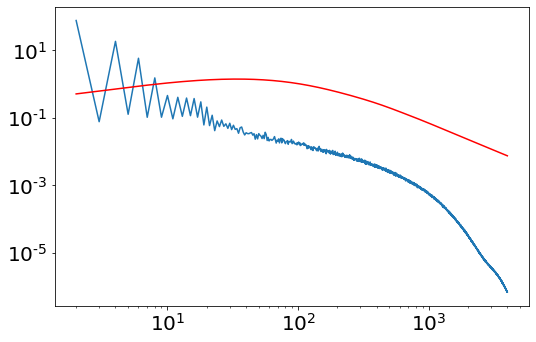

In [13]:
ls = np.arange(2, cppsim.lmax_qlm)

pl.loglog(ls, w(ls)*hp.alm2cl(MF_it[cppsim], MF_it[cppsim], cppsim.lmax_qlm, cppsim.mmax_qlm, None)[ls])

pl.plot(ls, cpp[ls]*w(ls), c='r')


In [14]:
#     # QE mean-field fed in as constant piece in the iteration steps:
#     mf_sims = np.unique(mc_sims_mf_it0 if not 'noMF' in version else np.array([]))
#     # if mpi.rank ==0:
#     mf0 = qlms_dd.get_sim_qlm_mf(k, mf_sims)  # Mean-field to subtract on the first iteration:
#     # mpi.barrier()
#     # mf0 = qlms_dd.get_sim_qlm_mf(k, mf_sims)  # Mean-field to subtract on the first iteration:
        
#     if simidx in mf_sims:  # We dont want to include the sim we consider in the mean-field...
#         Nmf = len(mf_sims)
#         mf0 = (mf0 - qlms_dd.get_sim_qlm(k, int(simidx)) / Nmf) * (Nmf / (Nmf - 1))


Text(0.5, 0, '$L$')

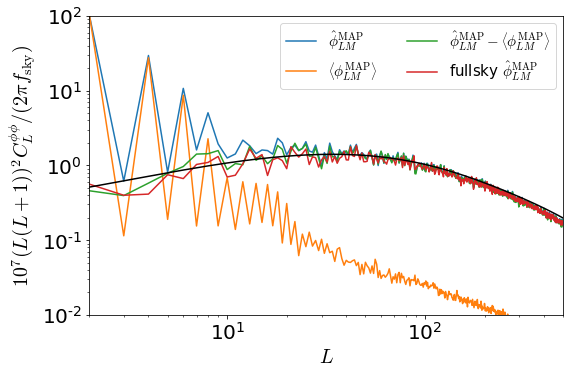

In [15]:
fig, ax = pl.subplots(1,1)

cppsim = plmaskpp_cstMF

ax.loglog(ls, w(ls)*hp.alm2cl(plmit[cppsim], plmit[cppsim], cppsim.lmax_qlm, cppsim.mmax_qlm, None)[ls]/ cppsim.fsky, label=r'$\hat \phi^{\mathrm{MAP}}_{LM}$', c='C0')

ax.loglog(ls, w(ls)*hp.alm2cl(MF_it[cppsim], MF_it[cppsim], cppsim.lmax_qlm, cppsim.mmax_qlm, None)[ls]/ cppsim.fsky, label=r'$\left<\phi^{\mathrm{MAP}}_{LM}\right>$', c='C1')


# ax.loglog(ls, w(ls)*hp.alm2cl(MF_it, MF_it, cppsim.lmax_qlm, cppsim.mmax_qlm, None)[ls]/ cppsim.fsky, label=r'$\left<\phi^{\mathrm{MAP}}_{LM}\right>$', c='C1')



ax.loglog(ls, w(ls)*hp.alm2cl(plmit_mf[cppsim], plmit_mf[cppsim], cppsim.lmax_qlm, cppsim.mmax_qlm, None)[ls]/ cppsim.fsky, label=r'$\hat \phi^{\mathrm{MAP}}_{LM} - \left<\phi^{\mathrm{MAP}}_{LM}\right>$', c='C2')



ax.loglog(ls, w(ls)*hp.alm2cl(plmit[idealpp_cstMF], plmit[idealpp_cstMF], cppsim.lmax_qlm, cppsim.mmax_qlm, None)[ls], label=r'fullsky $ \hat \phi^{\mathrm{MAP}}_{LM}$', c='C3')


ax.plot(ls, cpp[ls]*w(ls), c='k')


ax.legend()



ax.set_xlim(2, 500)
ax.set_ylim(1e-2, 1e2)

ax.legend(loc=1, fontsize= 15, ncol= 2)


ax.set_ylabel('$10^7 (L(L+1))^2  C_L^{\phi \phi} / (2\pi f_\mathrm{sky} )$')


ax.set_xlabel('$L$')



# pl.savefig(f"{plotdir}MF_{cppsim.label}_{nsims}_{isim}_iter{itmax}.pdf", bbox_inches='tight')

# Get the WF

In [16]:
wf_ideal, _ = idealpp_cstMF.get_wf_eff(itmax_sims=50, itmax_fid=15, version='', do_spline=True, lmin_interp=0, lmax_interp=None,  k=3, s=None, verbose=False)
wf_mask, _ = plmaskpp_cstMF.get_wf_eff(itmax_sims=50, itmax_fid=15, version='', do_spline=True, lmin_interp=0, lmax_interp=None,  k=3, s=None, verbose=False)


lmin_tlm:2, lmin_elm:2, lmin_blm:2
I use 40 sims to estimate the effective WF
lmin_tlm:2, lmin_elm:2, lmin_blm:2
I use 40 sims to estimate the effective WF


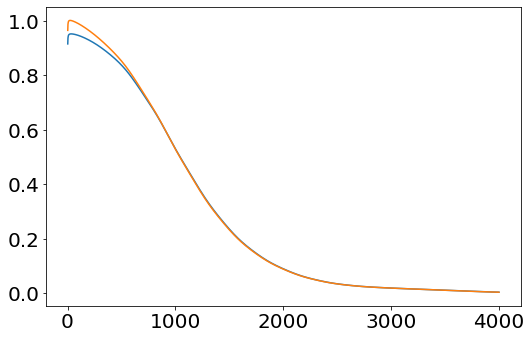

In [17]:
pl.plot(ls, wf_ideal[ls])
pl.plot(ls, wf_mask[ls])

In [18]:
cppsim.get_plm(isim, 50)

array([ 0.00000000e+00+0.00000000e+00j, -4.38194628e-18+0.00000000e+00j,
        2.51595617e-03+0.00000000e+00j, ...,
        8.04575442e-17+2.47312502e-17j, -9.56782844e-17-7.65824981e-18j,
       -5.54434766e-17+2.25455926e-17j])

In [19]:
cppsim.get_cpp(10, 50)

array([0.00000000e+00, 3.47755186e-36, 1.48609891e-06, ...,
       7.23368901e-26, 7.08607606e-26, 7.42740933e-26])

In [70]:
# Test if Mean field is in the Wf sim 
cppsim = plmaskpp_cstMF
wf_fid = cppsim.get_wf_fid(15, version='')
wf = np.zeros([nsims, len(wf_fid)])
wf_mf = np.zeros([nsims, len(wf_fid)])

itr = 50

nsims = 10

for isim in range(nsims):
    _plm = cppsim.get_plm(isim, itr)
    _plm_in = cppsim.get_plm(isim, itr)
    _plm_mf = cppsim.get_mf(itr, mc_sims, isim)
    print(isim)
    # wf[isim] = cppsim.get_cpp_itXinput(isim, itr) * utils.cli(cppsim.get_cpp_input(simidx)) / cppsim.fsky
    wf[isim] = get_cl(cppsim, _plm, _plm_in) * utils.cli(cppsim.get_cpp_input(simidx)) / cppsim.fsky
    wf_mf[isim] = get_cl(cppsim, _plm - _plm_mf) * utils.cli(cppsim.get_cpp_input(simidx)) / cppsim.fsky


# pl.plot(ls, np.mean(wf, axis=0)[ls]* utils.cli(wf_fid)[ls])
# pl.plot(ls, np.mean(wf_mf, axis=0)[ls]* utils.cli(wf_fid)[ls])
    
    
# pl.plot(ls, np.mean(wf - wf_mf, axis=0)[ls])


lmin_tlm:2, lmin_elm:2, lmin_blm:2
Removing sim 0 from MF estimate
0
Removing sim 1 from MF estimate
1
Removing sim 2 from MF estimate
2
Removing sim 3 from MF estimate
3
Removing sim 4 from MF estimate
4
Removing sim 5 from MF estimate
5
Removing sim 6 from MF estimate
6
Removing sim 7 from MF estimate
7
Removing sim 8 from MF estimate
8
Removing sim 9 from MF estimate
9


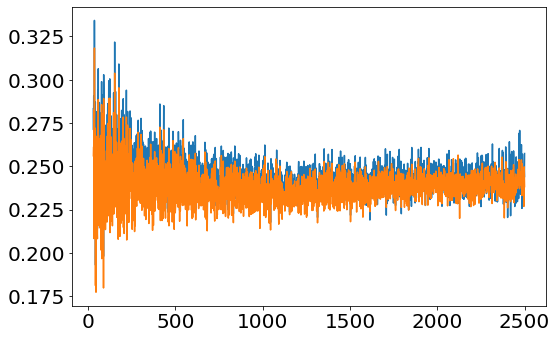

In [68]:
pl.plot(ls, np.mean(wf, axis=0)[ls]* utils.cli(wf_fid)[ls])
pl.plot(ls, np.mean(wf_mf, axis=0)[ls]* utils.cli(wf_fid)[ls])


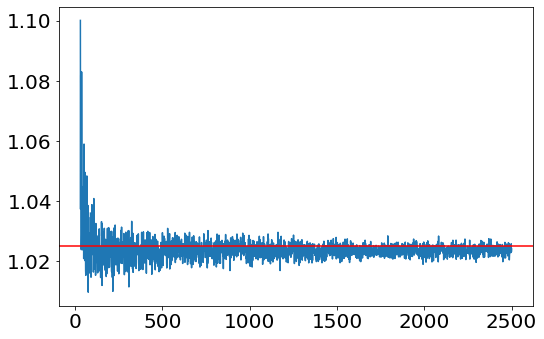

In [77]:
pl.plot(ls, np.mean(wf, axis=0)[ls]* utils.cli(np.mean(wf_mf, axis=0))[ls])
pl.axhline(y=1+1/40, c='r')

In [20]:
# wf_id, _ = idealpp_cstMF.get_wf_eff(itmax_sims= 50, mf=False, version='wN1', lmin_interp=lmin_interp, lmax_interp=lmax_interp, do_spline=False)
# wf_ma, _ = plmaskpp_cstMF.get_wf_eff(itmax_sims= 50, mf=False, version='wN1', lmin_interp=lmin_interp, lmax_interp=lmax_interp, do_spline=False)
# wf_fid = idealpp_cstMF.get_wf_fid(15, version='wN1')
# pl.plot(ls, wf_id[ls]*utils.cli(wf_fid)[ls])
# pl.plot(ls, wf_ma[ls]*utils.cli(wf_fid)[ls])

wf_id, _ = idealpp_cstMF.get_wf_eff(itmax_sims= 50, mf=False, version='', lmin_interp=lmin_interp, lmax_interp=lmax_interp, do_spline=False)
wf_ma, _ = plmaskpp_cstMF.get_wf_eff(itmax_sims= 50, mf=False, version='', lmin_interp=lmin_interp, lmax_interp=lmax_interp, do_spline=False)
wf_fid = idealpp_cstMF.get_wf_fid(15, version='')

pl.plot(ls, wf_id[ls]*utils.cli(wf_fid)[ls])
pl.plot(ls, wf_ma[ls]*utils.cli(wf_fid)[ls])


wf_fid = idealpp_cstMF.get_wf_fid(15, version='wN1_end')

pl.plot(ls, wf_id[ls]*utils.cli(wf_fid)[ls])
pl.plot(ls, wf_ma[ls]*utils.cli(wf_fid)[ls])



NameError: name 'lmin_interp' is not defined

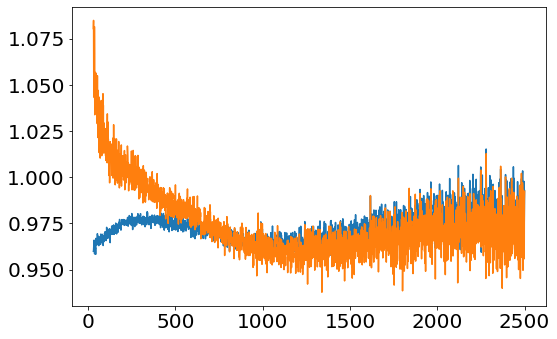

lmin_tlm:2, lmin_elm:2, lmin_blm:2
Adding n1 in iterations
 [00:00:03]  > 00%
lmin_tlm:2, lmin_elm:2, lmin_blm:2
I use 40 sims to estimate the effective WF
lmin_tlm:2, lmin_elm:2, lmin_blm:2
Adding n1 in iterations
 [00:00:03]  > 00%
lmin_tlm:2, lmin_elm:2, lmin_blm:2
I use 40 sims to estimate the effective WF


(0.0, 2500.0)

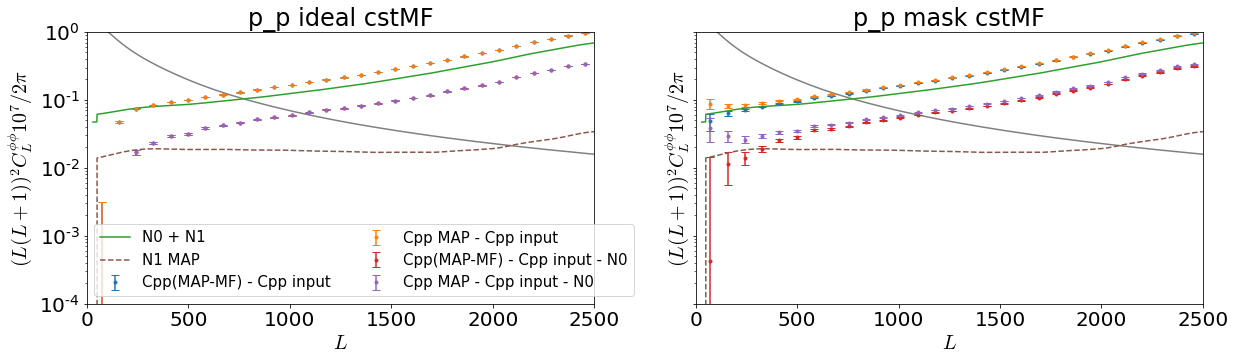

In [93]:
simidx = 0

fig, axs= pl.subplots(1, 2, figsize=(20, 5), sharex=True, sharey=True)
# fig, axs= pl.subplots(1, 1, figsize=(10, 5), sharex=True, sharey=True)


lmin = 30
lmax = 2500
ls = np.arange(lmin, lmax+1)
nbin = 30
# edges = np.geomspace(lmin, lmax, nbin, dtype='int')

lmin_interp = lmin
lmax_interp= lmax

edges = np.linspace(lmin_interp, lmax_interp, nbin, dtype='int')

it = 0
for cppsim, ax in zip([idealpp_cstMF, plmaskpp_cstMF], axs):
    ax.plot(ls, cpp[ls]*w(ls), c='grey')
    
    # ax.plot(ls, w(ls)* cppsim.get_cpp_input(simidx)[ls]) 
    N0_biased, N1_biased, rgg_fid, rgg_true = cppsim.get_N0_N1_iter(itermax=0, version='wN1')
    
    # wf_it, _ = cppsim.get_wf_eff(itmax_sims= 50, mf=MF_it[cppsim], version='wN1', lmin_interp=lmin_interp, lmax_interp=lmax_interp, do_spline=False)
    # wf_it, _ = cppsim.get_wf_eff(itmax_sims= 50, mf=False, version='', lmin_interp=lmin_interp, lmax_interp=lmax_interp, do_spline=False)
    wf_it, _ = idealpp_cstMF.get_wf_eff(itmax_sims= 0, version='', lmin_interp=lmin_interp, lmax_interp=lmax_interp, do_spline=False) 
    # wf_it, _ = idealpp_cstMF.get_wf_eff(itmax_sims= 15, version='wN1', lmin_interp=lmin_interp, lmax_interp=lmax_interp, do_spline=True) 
    
#     plm_it = cppsim.get_plm(simidx, it)
#     if cppsim == plmaskpp_cstMF:
#         plm_mf_it = cppsim.get_mf(it, mc_sims, simidx)
#     else:
#         plm_mf_it = 0
        
        
    # plot_bnd(bnd(get_cl(cppsim, plm_it)[:lmax+1] *cli( wf_it[:lmax+1])**2 / cppsim.fsky, lmin, lmax, edges, w),  ax=ax, label='Cpp MAP ')
    # ax.plot(ls, w(ls)*(get_cl(cppsim, plm_it - plm_mf_it)[ls] *cli( wf_it[ls])**2 / cppsim.fsky) , label='Cpp MAP-MF')
    # ax.plot(ls, w(ls)*(get_cl(cppsim, plm_it)[ls] *cli( wf_it[ls])**2 / cppsim.fsky) , label='Cpp MAP ')

    # plot_bnd(bnd(cppsim.get_cpp(simidx, it, plm_mf=None)[:lmax+1] *cli( wf_it[:lmax+1])**2 / cppsim.fsky - cppsim.get_cpp_input(simidx)[:lmax+1], lmin, lmax, edges, w),  ax=ax, label='Cpp MAP - Cpp input')
    plot_bnd(bnd(get_cl(cppsim, plmit[cppsim] - MF_it[cppsim])[:lmax+1] *cli( wf_it[:lmax+1])**2 / cppsim.fsky - cppsim.get_cpp_input(simidx)[:lmax+1], lmin, lmax, edges, w),  ax=ax, label='Cpp(MAP-MF) - Cpp input')
    plot_bnd(bnd(get_cl(cppsim, plmit[cppsim])[:lmax+1] *cli( wf_it[:lmax+1])**2 / cppsim.fsky - cppsim.get_cpp_input(simidx)[:lmax+1], lmin, lmax, edges, w),  ax=ax, label='Cpp MAP - Cpp input')
    # ax.plot(ls, w(ls)*(get_cl(cppsim, plm_it - plm_mf_it)[ls] *cli( wf_it[ls])**2 / cppsim.fsky - cppsim.get_cpp_input(simidx)[ls]), label='Cpp MAP - Cpp input')

    
    # Reff = idealpp_noaberration.get_R_eff(lmin_interp=lmin_interp, lmax_interp=lmax_interp)
    # RDN0 = cppsim.get_rdn0_map(simidx, useReff=True, Reff=Reff, lmin_interp=lmin_interp, lmax_interp=lmax_interp)
    # ax.plot(ls,  w(ls) * (RDN0[ls] + N1_biased[ls]), label='RDN0 + N1')
    ax.plot(ls,  w(ls) * (N0_biased[ls] +N1_biased[ls]) , label='N0 + N1' )



    # plot_bnd(bnd(cppsim.get_cpp(simidx, it)[:lmax+1] * cli(wf_it[:lmax+1])**2 / cppsim.fsky - RDN0[:lmax+1] - cppsim.get_cpp_input(simidx)[:lmax+1] , lmin, lmax, edges, w),  ax=ax, label='Cpp MAP -  Cpp input - RDN0')

    # plot_bnd(bnd(cppsim.get_cpp(simidx, it)[:lmax+1] *cli(wf_it[:lmax+1])**2 / cppsim.fsky - N0_biased[:lmax+1] - cppsim.get_cpp_input(simidx)[:lmax+1]  , lmin, lmax, edges, w),  ax=ax,  label='Cpp MAP - Cpp input - N0')
    plot_bnd(bnd(get_cl(cppsim, plmit[cppsim]- MF_it[cppsim])[:lmax+1] *cli( wf_it[:lmax+1])**2 / cppsim.fsky -  N0_biased[:lmax+1] - cppsim.get_cpp_input(simidx)[:lmax+1], lmin, lmax, edges, w),  ax=ax, label='Cpp(MAP-MF) - Cpp input - N0')
    plot_bnd(bnd(get_cl(cppsim, plmit[cppsim])[:lmax+1] *cli( wf_it[:lmax+1])**2 / cppsim.fsky -  N0_biased[:lmax+1] - cppsim.get_cpp_input(simidx)[:lmax+1], lmin, lmax, edges, w),  ax=ax, label='Cpp MAP - Cpp input - N0')

    # plot_bnd(bnd( N1_biased[:lmax+1], lmin, lmax, edges, w),  ax=ax,  label='N1 MAP')
    ax.plot(ls, w(ls)* N1_biased[ls], label='N1 MAP', ls='--')


    ax.set_title(cppsim.label)
    # ax.set_xscale('log')    
    ax.set_yscale('log')    
    ax.set_ylabel('$(L(L+1))^2  C_L^{\phi \phi}  10^7 / 2 \pi$')
    ax.set_xlabel('$L$')

axs[0].legend( ncol=2)

# ax.set_ylim(-1e-2, 1e-2)
ax.set_ylim(1e-4, 1)
ax.set_xlim(0, lmax)
    

# Plot gradient terms

In [14]:
# cppsim = plmaskpp_cstMF

In [49]:
simidx = 0 
tol = 5
tol_iter = 10 ** (- tol) 
itlib = {}
for cppsim in [plmaskpp_cstMF, idealpp_cstMF]:
    itlib[cppsim] = cppsim.param.get_itlib(cppsim.k, simidx, cppsim.version, tol_iter)


Starting get itlib for /pscratch/sd/l/llegrand/lenscarfrecs/cmbs4_planckmask_lminsim2_cstMF/p_p_sim0000
CL[1]  5920711888927.8
GL[1] (before subtraction)  5920686548755.26
GL[1] (after subtraction)  -25340172.540039062
 Deflection std 0.00e+00 amin
*** alm_filter_ninv: switching to same ninv_geometry but with unit weights
CL[1]  5920711888927.8
GL[1] (before subtraction)  5920686548755.26
GL[1] (after subtraction)  -25340172.540039062
 Deflection std 0.00e+00 amin


In [50]:
itmax = 50

In [51]:
cppsim.cacher_param.cache?

Signature: cppsim.cacher_param.cache(fn, obj)
Docstring: <no docstring>
File:      /global/u2/l/llegrand/lenscarf/lenscarf/cachers.py
Type:      method


In [52]:
mf_it = {}
gqd = {}
mf_qe = {}
plmmap = {}
plmit = {}

# fn_graddet = lambda isim, itmax : f'graddet_{isim}_{itmax}'
# fn_gradlik = lambda isim, itmax : f'gradlik_{isim}_{itmax}'

# for cppsim in [plmaskpp_cstMF, idealpp_cstMF]:
    
#     if np.any([not cppsim.cacher_param.is_cached(fn) for fn in [fn_gradlik(isim, itmax), fn_graddet(isim, itmax)]]):
#         _mf_it = itlib[cppsim].calc_graddet(itmax-1, 'p')
#         _gqd = itlib[cppsim].calc_gradlik(itmax-1, 'p', iwantit=True)
#         cppsim.cacher_param.cache(fn_graddet(isim, itmax), _mf_it)
#         cppsim.cacher_param.cache(fn_gradlik(isim, itmax), _gqd)
#     mf_it[cppsim] = cppsim.cacher_param.load(fn_graddet(isim, itmax))
#     gqd[cppsim] = cppsim.cacher_param.load(fn_gradlik(isim, itmax))
#     mf_qe[cppsim] = cppsim.get_mf0(simidx)    


for cppsim in [plmaskpp_cstMF, idealpp_cstMF]:
    fn_wf = 'wflm_%s_it%s' % (cppsim.k.lower(), itmax - 1)
    if not itlib[cppsim].wf_cacher.is_cached(fn_wf):
        _gqd = itlib[cppsim].calc_gradlik(itmax-1, 'p', iwantit=True)
        itlib[cppsim].wf_cacher.cache(fn_wf, _gqd)
    gqd[cppsim] = itlib[cppsim].wf_cacher.load(fn_wf)
    
    mf_qe[cppsim] = cppsim.get_mf0(simidx)   
    mf_it[cppsim] = itlib[cppsim].calc_graddet(itmax-1, 'p')
    
    
    
    plmmap[cppsim] = cppsim.get_plm(simidx, itmax)
    plmit[cppsim] = almxfl(cppsim, gqd[cppsim] + mf_it[cppsim], cls_unl['pp'])

In [53]:
ls = np.arange(2, cppsim.param.lmax_qlm)

In [54]:
# gprior = almxfl(cppsim, plmmap, -1 / 2 /  cls_unl['pp'])

In [55]:
plotdir = './plots/'

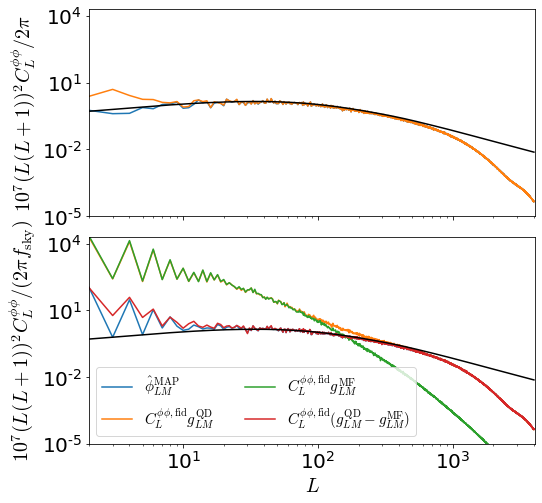

In [73]:
fig, axs = pl.subplots(2, 1, sharex=True, sharey= True, figsize = (8,8))
fig.subplots_adjust(hspace=0.1)



cppsim = idealpp_cstMF
axs[0].loglog(ls, w(ls)*get_cl(cppsim, plmmap[cppsim])[ls], label=r'$\hat \phi^{\mathrm{MAP}}$', c='C0')
axs[0].loglog(ls, w(ls)*get_cl(cppsim, gqd[cppsim])[ls]*cpp[ls]**2, label=r'$C_L^{\phi\phi, \mathrm{fid}}  g^{QD}_{LM} $', c='C1')

# axs[1].loglog(ls, pp2kk(ls)*get_cl(cppsim, plmmap[cppsim])[ls], ls= '--', c='C0')
# axs[1].loglog(ls, pp2kk(ls)*get_cl(cppsim, gqd[cppsim])[ls]*cpp[ls]**2, ls = '--', c='C1')




cppsim =plmaskpp_cstMF
axs[1].loglog(ls, w(ls)*get_cl(cppsim, plmmap[cppsim])[ls] / cppsim.fsky, label=r'$\hat \phi^{\mathrm{MAP}}_{LM}$', c='C0')
axs[1].loglog(ls, w(ls)*get_cl(cppsim, gqd[cppsim])[ls]*cpp[ls]**2 / cppsim.fsky, label=r'$C_L^{\phi\phi, \mathrm{fid}}  g^\mathrm{QD}_{LM} $', c='C1')
axs[1].loglog(ls, w(ls)*get_cl(cppsim, mf_it[cppsim])[ls]*cpp[ls]**2 / cppsim.fsky,  label=r'$C_L^{\phi\phi, \mathrm{fid}}  g^\mathrm{MF}_{LM}$', c='C2')

axs[1].loglog(ls, w(ls)*get_cl(cppsim, plmit[cppsim])[ls]/ cppsim.fsky , label=r'$C_L^{\phi\phi, \mathrm{fid}}  (g^\mathrm{QD}_{LM} - g^\mathrm{MF}_{LM})$', c='C3' )




axs[0].plot(ls, w(ls)*cpp[ls], c='k')
axs[1].plot(ls, w(ls)*cpp[ls], c='k')


axs[0].set_xlim(2, 4096)
axs[0].set_ylim(1e-5, 2e4)

axs[1].legend(loc=3, fontsize= 15, ncol= 2)

# axs[0].set_ylabel('$(L(L+1))^2  C_L^{\phi \phi} /4$')
# axs[1].set_ylabel('$(L(L+1))^2  C_L^{\phi \phi} /4$')

axs[0].set_ylabel('$10^7 (L(L+1))^2  C_L^{\phi \phi} / 2\pi$')
axs[1].set_ylabel('$10^7 (L(L+1))^2  C_L^{\phi \phi} / (2\pi f_\mathrm{sky} )$')


axs[1].set_xlabel('$L$')



pl.savefig(f"{plotdir}gradients_{idealpp_cstMF.label}_{plmaskpp_cstMF.label}_iter{itmax}.pdf", bbox_inches='tight')

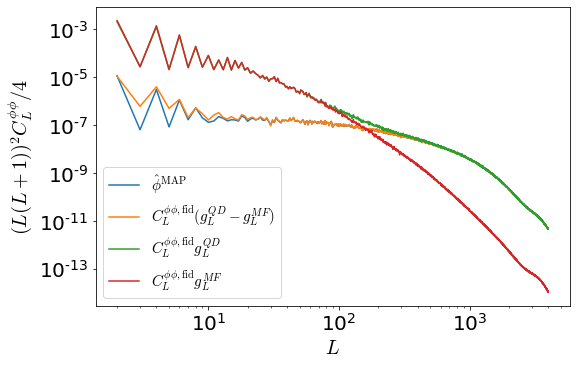

In [39]:

# for cppsim in [plmaskpp_cstMF, idealpp_cstMF]:

cppsim = plmaskpp_cstMF

if cppsim == plmaskpp_cstMF:


    pl.loglog(ls, pp2kk(ls)*get_cl(cppsim, plmmap[cppsim])[ls], label=r'$\hat \phi^{\mathrm{MAP}}$')
    pl.loglog(ls, pp2kk(ls)*get_cl(cppsim, plmit[cppsim])[ls], label=r'$C_L^{\phi\phi, \mathrm{fid}}  (g^{QD}_L - g^{MF}_L)$' )

    pl.loglog(ls, pp2kk(ls)*get_cl(cppsim, gqd[cppsim])[ls]*cpp[ls]**2, label=r'$C_L^{\phi\phi, \mathrm{fid}}  g^{QD}_L $')
    pl.loglog(ls, pp2kk(ls)*get_cl(cppsim, mf_it[cppsim])[ls]*cpp[ls]**2, label=r'$C_L^{\phi\phi, \mathrm{fid}}  g^{MF}_L $')

else:
    pl.loglog(ls, pp2kk(ls)*get_cl(cppsim, plmmap[cppsim])[ls], label=r'$\hat \phi^{\mathrm{MAP}}$')

    pl.loglog(ls, pp2kk(ls)*get_cl(cppsim, gqd[cppsim])[ls]*cpp[ls]**2, label=r'$C_L^{\phi\phi, \mathrm{fid}}  g^{QD}_L $')

# pl.loglog(ls, pp2kk(ls)*get_cl(cppsim, mf_qe)[ls]/resp_QE[ls]**2, label=r'MF QE')

# pl.plot(ls, pp2kk(ls)*cpp[ls], c='k')

# pl.loglog(ls, -pp2kk(ls)*get_cl(cppsim, plmmap, plmit)[ls], label="$- C_L^{\hat \phi^{\mathrm{MAP}}, C_L^{\phi\phi, \mathrm{fid}}  (g^{QD}_L - g^{MF}_L)}$")

# pl.title(f"{cppsim.label}, iter {itmax}")
pl.ylabel('$(L(L+1))^2  C_L^{\phi \phi} /4$')
pl.xlabel('$L$')
pl.legend(loc=3)
pl.savefig(f"{plotdir}gradients_{cppsim.label}_iter{itmax}.pdf", bbox_inches='tight')

In [ ]:
# pl.loglog(ls, pp2kk(ls)*get_cl(cppsim, plmmap)[ls], label=r'$\hat \phi^{\mathrm{MAP}}$')
pl.loglog(ls, get_cl(cppsim, gprior)[ls], label=r'$ g^{PR}_L$' )

pl.loglog(ls, get_cl(cppsim, gqd)[ls], label=r'$ g^{QD}_L $')
pl.loglog(ls, get_cl(cppsim, mf_it)[ls], label=r'$ g^{MF}_L $')


pl.legend()

In [ ]:
pl.loglog(ls, get_cl(cppsim, gqd - mf_it + gprior)[ls], label=r'$ g^{MF}_L $')
